# NYC Yellow Taxis Data Cleaning 

In [36]:
# Some imports 
import os 

import graphs
import manipulation

import pandas as pd  
import warnings
warnings.filterwarnings("ignore")
import datetime
import pyspark
# some Spark related imports we will use hereafter
from pyspark.ml.feature import VectorAssembler
import sys

from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import HiveContext
from pyspark.sql import SQLContext
conf = pyspark.SparkConf().setAppName("taxi_ny")
conf = (SparkConf()
       .set("spark.executor.memoryOverhead", "8192")
       .set("spark.kryoserializer.buffer.max", "1024"))

sc.stop()
sc = SparkContext(conf=conf)

22/05/21 11:58:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Build a SparkSession instance if one does not exist. Notice that we can only have one per JVM

spark = SparkSession\
    .builder\
    .appName("taxi_ny")\
    .config("spark.sql.shuffle.partitions",6)\
    .getOrCreate()

In [15]:
# Read the dataset 
df_raw = spark.read.csv("trip data|yellow_tripdata_2010-11.csv", header="true", inferSchema="true", sep=',')
df_raw1 = spark.read.csv("trip data|yellow_tripdata_2010-12.csv", header="true", inferSchema="true", sep=',')

In [5]:
# check the data - schema, show and and count
df_raw.printSchema()
df_raw.show(2,vertical=True)
df_raw.count()

root
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)

-RECORD 0---------------------------------
 vendor_id          | VTS                 
 pickup_datetime    | 2010-11-01 05:13:00 
 dropoff_datetime   | 2010-11-01 05:13:00 
 passenger_c

100

In [6]:
# check the data - schema, show and and count
df_raw.printSchema()
df_raw.show(2,vertical=True)
df_raw.count()

root
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)

-RECORD 0---------------------------------
 vendor_id          | VTS                 
 pickup_datetime    | 2010-11-01 05:13:00 
 dropoff_datetime   | 2010-11-01 05:13:00 
 passenger_c

100

In [7]:
# Check some column statistics, one by one.
for cl in df_raw.columns:
    df_raw.describe(cl).show()

+-------+---------+
|summary|vendor_id|
+-------+---------+
|  count|      100|
|   mean|     null|
| stddev|     null|
|    min|      CMT|
|    max|      VTS|
+-------+---------+

+-------+-------------------+
|summary|    pickup_datetime|
+-------+-------------------+
|  count|                100|
|   mean|               null|
| stddev|               null|
|    min|2010-11-01 05:13:00|
|    max|2010-11-13 05:06:00|
+-------+-------------------+

+-------+-------------------+
|summary|   dropoff_datetime|
+-------+-------------------+
|  count|                100|
|   mean|               null|
| stddev|               null|
|    min|2010-11-01 05:13:00|
|    max|2010-11-13 05:13:00|
+-------+-------------------+

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|               100|
|   mean|              1.86|
| stddev|1.4356218516761647|
|    min|                 1|
|    max|                 6|
+-------+------------------+

+-------+------

In [8]:
list_dataframes = [df_raw, df_raw1]
list_pd_dfs = []

for df in list_dataframes:
    #print(df)
    df_pd=df.toPandas() 
    list_pd_dfs.append(df_pd)

In [9]:
df_clean = manipulation.clean_join_dfs(list_pd_dfs)

In [10]:
df_clean[1]

passenger_count  duration  trip_distance  tip  tip_amount  total_amount
0                 1       8.0           1.99    0         0.0          8.30
1                 1       4.0           0.78    1         1.0          6.10
2                 2      22.0           2.06    0         0.0         12.20
3                 1      14.0           5.03    0         0.0         13.80
4                 1      23.0           2.61    0         0.0         13.00
..              ...       ...            ...  ...         ...           ...
95                1      25.0           3.90    0         0.0         15.80
96                1      19.0           1.30    0         0.0         11.00
97                2      52.0          17.90    0         0.0         50.07
98                1       3.0           0.70    0         0.0          5.00
99                1       4.0           0.60    0         0.0          4.60

[99 rows x 6 columns]

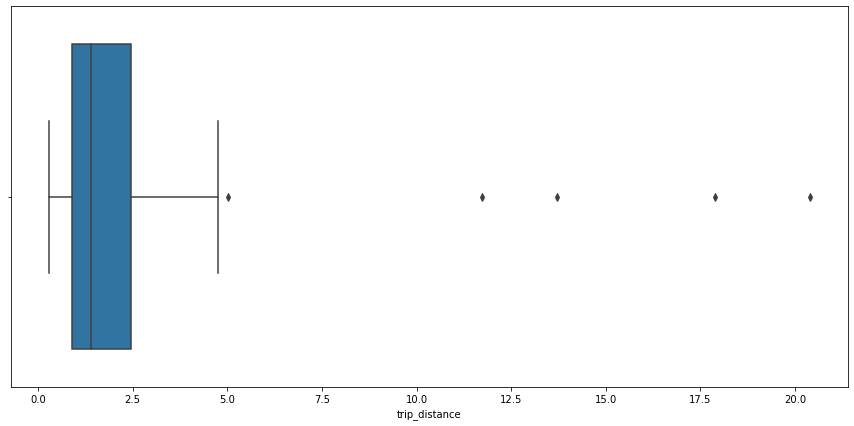

In [11]:
graphs.boxPlot(df_clean[1].trip_distance)

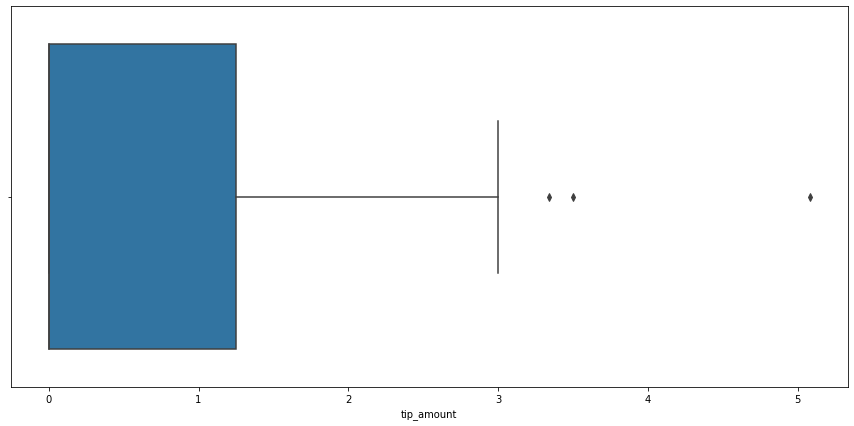

In [12]:
graphs.boxPlot(df_clean[1].tip_amount)

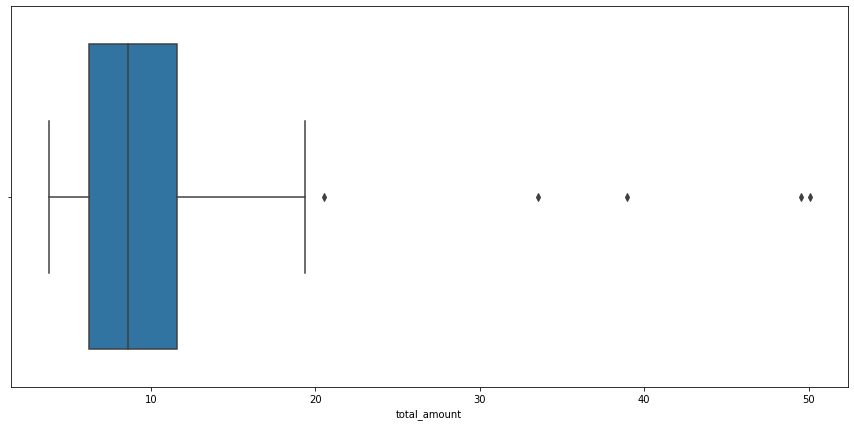

In [13]:
graphs.boxPlot(df_clean[1].total_amount)

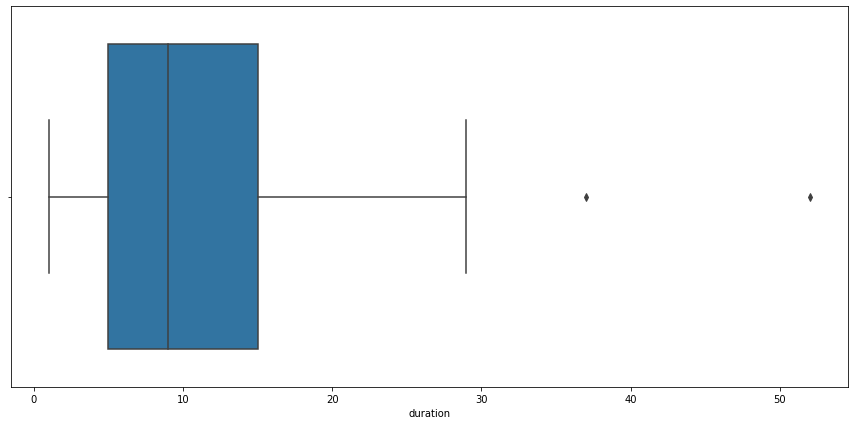

In [14]:
graphs.boxPlot(df_clean[1].duration)

In [15]:
df_clean

[    passenger_count  duration  trip_distance  tip  tip_amount  total_amount
 1                 1      15.0           3.92    1        4.00         16.70
 2                 5      27.0           3.90    1        3.00         19.80
 3                 1       4.0           0.92    0        0.00          6.00
 4                 2      13.0           3.02    1        1.75         13.35
 5                 5      13.0           1.28    0        0.00          9.20
 ..              ...       ...            ...  ...         ...           ...
 95                1      24.0           3.76    0        0.00         15.00
 96                2      12.0           3.00    1        2.00         13.00
 97                5      20.0           5.23    0        0.00         16.20
 98                1       6.0           0.72    0        0.00          5.40
 99                1      18.0           2.86    0        0.00         12.60
 
 [99 rows x 6 columns],
     passenger_count  duration  trip_distance  tip

In [16]:
no_out_df_list = manipulation.no_outlier_dfs(df_clean)

2


In [17]:
no_out_df_list[0]

passenger_count  duration  trip_distance  tip  tip_amount  total_amount
3                 1       4.0           0.92    0        0.00          6.00
4                 2      13.0           3.02    1        1.75         13.35
7                 1      13.0           3.30    0        0.00         11.90
8                 1      11.0           0.78    0        0.00          8.80
10                3      15.0           2.70    0        0.00         11.50
..              ...       ...            ...  ...         ...           ...
92                2       8.0           1.05    0        0.00          6.20
94                2       7.0           0.95    0        0.00          5.80
96                2      12.0           3.00    1        2.00         13.00
98                1       6.0           0.72    0        0.00          5.40
99                1      18.0           2.86    0        0.00         12.60

[65 rows x 6 columns]

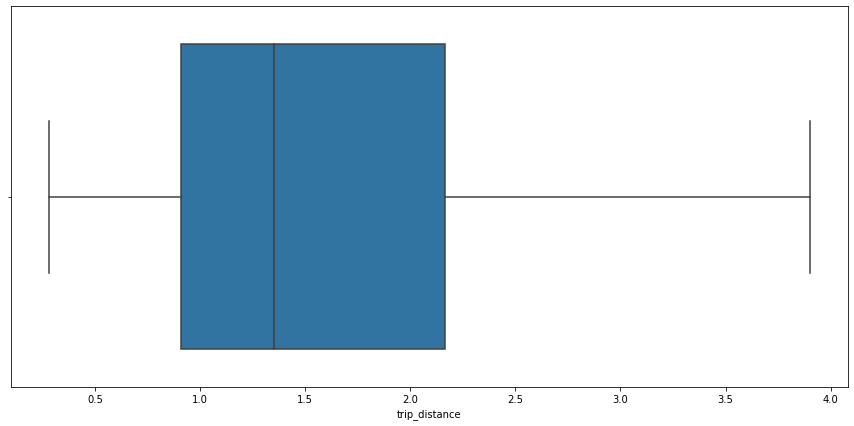

In [20]:
graphs.boxPlot(no_out_df_list[1].trip_distance)

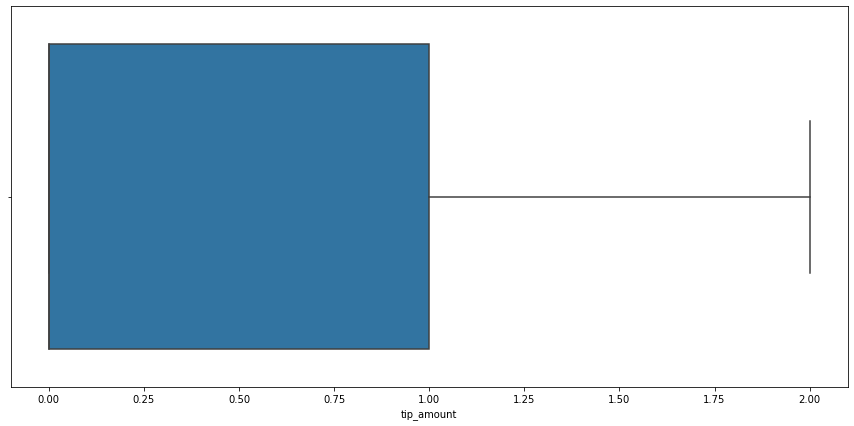

In [21]:
graphs.boxPlot(no_out_df_list[1].tip_amount)

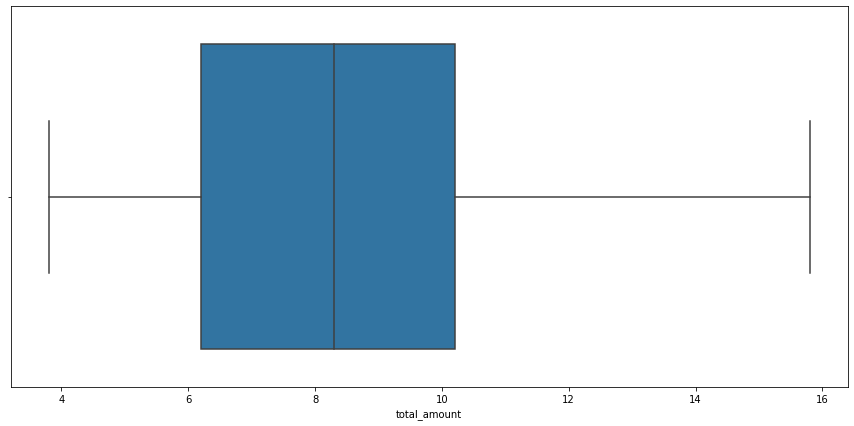

In [23]:
graphs.boxPlot(no_out_df_list[1].total_amount)

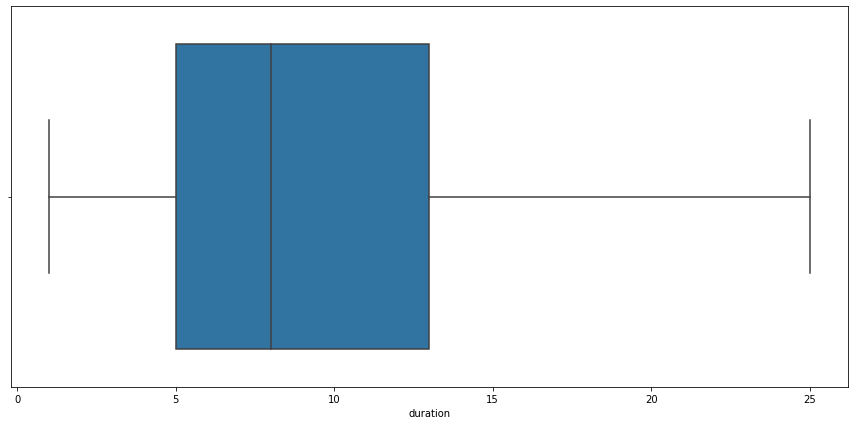

In [24]:
graphs.boxPlot(no_out_df_list[1].duration)

In [25]:
no_out_df_list[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 3 to 99
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  65 non-null     int32  
 1   duration         65 non-null     float64
 2   trip_distance    65 non-null     float64
 3   tip              65 non-null     int64  
 4   tip_amount       65 non-null     float64
 5   total_amount     65 non-null     float64
dtypes: float64(4), int32(1), int64(1)
memory usage: 3.3 KB


In [26]:
df_final = no_out_df_list[0].append(no_out_df_list[1])

In [27]:
df_final

passenger_count  duration  trip_distance  tip  tip_amount  total_amount
3                 1       4.0           0.92    0        0.00          6.00
4                 2      13.0           3.02    1        1.75         13.35
7                 1      13.0           3.30    0        0.00         11.90
8                 1      11.0           0.78    0        0.00          8.80
10                3      15.0           2.70    0        0.00         11.50
..              ...       ...            ...  ...         ...           ...
94                1      11.0           1.40    0        0.00          8.20
95                1      25.0           3.90    0        0.00         15.80
96                1      19.0           1.30    0        0.00         11.00
98                1       3.0           0.70    0        0.00          5.00
99                1       4.0           0.60    0        0.00          4.60

[124 rows x 6 columns]

In [28]:
df_final2 = df_final[['duration','trip_distance','tip_amount','total_amount']]

In [29]:
spark = SparkSession\
    .builder\
    .appName("taxi_ny")\
    .config("spark.sql.shuffle.partitions",6)\
    .getOrCreate()

In [30]:
spark = SparkSession\
    .builder\
    .appName("taxi_ny2")\
    .config("spark.sql.shuffle.partitions",6)\
    .getOrCreate()

In [31]:
df_spark = spark.createDataFrame(df_final)

In [32]:
df_spark2 = spark.createDataFrame(df_final2)

In [37]:
cls2 = ["passenger_count","duration","trip_distance","tip","tip_amount","total_amount"]
#cls2 = ["duration","trip_distance","tip_amount","total_amount"]


cols_corr = cls2

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols_corr, outputCol=vector_col)
df_vector = assembler.transform(df_spark).select(vector_col)

corrmatrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()

22/05/21 12:02:53 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/21 12:02:53 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


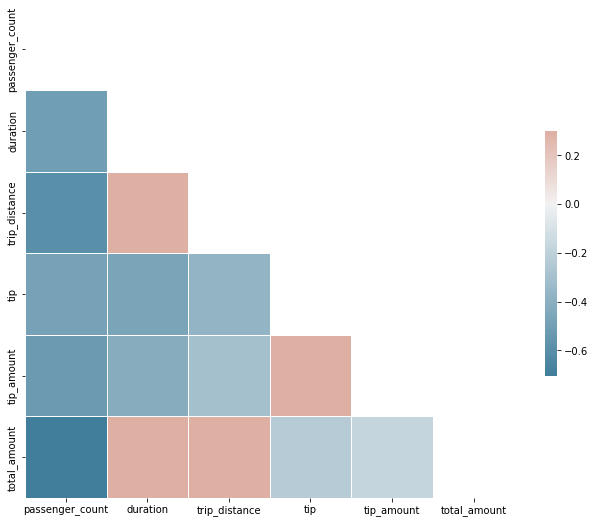

In [38]:
# with tip and passenger_count
df_plot = pd.DataFrame(data = corrmatrix, index=cols_corr, columns=cols_corr)
graphs.plotCorrelationMatrix1(df_plot)

In [40]:
cls2 = ["duration","trip_distance","tip_amount","total_amount"]

cols_corr = cls2

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols_corr, outputCol=vector_col)
df_vector = assembler.transform(df_spark2).select(vector_col)

corrmatrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()

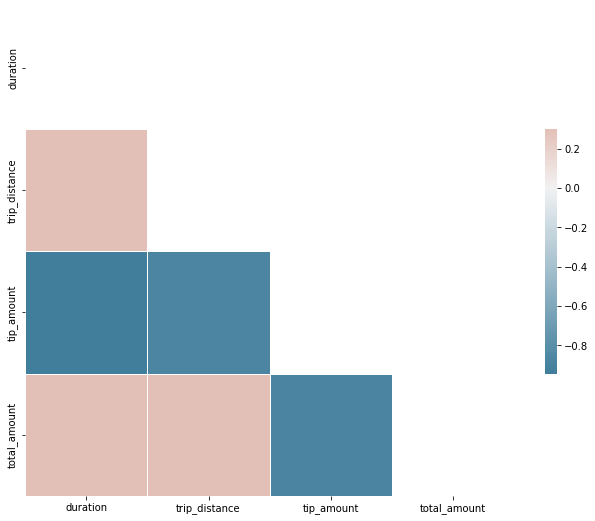

In [41]:
# without tip and passenger_count
df_plot = pd.DataFrame(data = corrmatrix, index=cols_corr, columns=cols_corr)
graphs.plotCorrelationMatrix1(df_plot)

In [112]:
# Drop total_amount, passenger_count, tip

In [43]:
# send dataset to csv to then use it in aws/ ml model notebook
df_final.to_csv('yellow_data_final.csv')